# OSM-Feature: Straßentypen (`highways`)

In diesem Notebook wird das Feature `Straßentyp` (entspricht ` highways`in OSM) extrahiert und analysiert.

Vorgehen:
- Herunterladen der OSM-Daten für Berlin
- Extrahieren des Fahrradnetzwerks
- Zuschneiden auf die Berliner Grenzen

&rarr; nützlich für geografische Analysen oder Visualisierungen von Fahrradinfrastruktur in Berlin

Die Bibliothek `pyrosm` wird genutzt, um Geodaten aus OpenStreetMap (OSM) für Berlin zu extrahieren, speziell das **Fahrradnetzwerk**.

### Was `network_type="cycling"` umfasst

- Verwenden von `pyrosm` und Extrahieren des Fahrradnetzwerk mit `network_type="cycling"` &rarr; es werden alle OSM-Elemente einbezogen, die für Fahrradfahrende relevant sind
- Dies schließt folgendes ein:
    - **Explizite Fahrradwege**: Alle Wege und Relationen, die mit dem Tag cycleway gekennzeichnet sind und speziell für Fahrradfahrer vorgesehen sind.
    - **Straßen mit Fahrradnutzung**: Alle allgemeinen Straßen (highway), die für Fahrradfahrende zugänglich sind, basierend auf zusätzlichen Tags wie bicycle=yes oder ähnlichen Tags, die ihre Eignung für Fahrräder anzeigen.

In [321]:
import pyrosm
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd

In [322]:
# download pbf file
# fp = pyrosm.get_data("Berlin", directory="data") # startet Download

# Unterdrücken von FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# OSM-Daten wurden bereits heruntergeladen wurden und wurden im Verzeichnis data gespeichert
fp = "../../data/berlin-latest.osm.pbf"

berlin_osm = pyrosm.OSM(fp)

# Extrahieren des Fahrradnetzwerks für Berlin
# cycle_net_berlin = berlin_osm.get_network(network_type="cycling")

*Anmerkung*: Beim Ausführen des Codes erscheint eine `FutureWarning` bezüglich `chained assignment`, die darauf hinweist, dass `pyrosm` eine `chained assignment` verwendet, die sich in zukünftigen pandas-Versionen ändern könnte. Daher wird die Warnung vorerst unterdrückt. 

### Extrahieren des Fahrradnetzwerks

`cycle_net_berlin` enthält alle für Fahrräder befahrbaren Straßen/Wege und relevante Tags, sofern diese bei der Extraktion durch `pyrosm` geladen und verarbeitet wurden. Allerdings wird standardmäßig nicht jedes mögliche Attribut extrahiert; &rarr; Daher explizit angeben, welche zusätzlichen Attribute (`extra_attributes`) benötigt werden.

&rarr; Argument `extra_attributes` hinzufügen, um sicherzustellen, dass z.B. das Attribut `highway` beim Extrahieren enthalten ist.


In [323]:
# Extrahieren des Fahrradnetzwerks für Berlin MIT extra_attributes=["highway"]
cycle_net_berlin = berlin_osm.get_network(network_type="cycling", extra_attributes=["highway"])

## Gibt es leeren Geometrien

In [342]:
# Finden der leeren Geometrien
leere_geom_indizes = cycle_net_berlin.geometry.is_empty
leere_geometrien = cycle_net_berlin[leere_geom_indizes]

# Überprüfen der Anzahl der leeren Geometrien
print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


### Überschneiden des Fahrradnetzwerks mit den Berliner Grenzen

In [346]:
# crop to Berlin extent: get administrative boundary from pbf
boundaries = berlin_osm.get_boundaries(name="Berlin")
berlin_boundary = boundaries[boundaries.name=="Berlin"].reset_index().geometry[0]

# intersect with Berlin boundary / Geometrie des Fahrradnetzwerkes innerhalb der Grenzen von Berlin
geom = cycle_net_berlin.intersection(berlin_boundary)

# the intersection only return a geometry - to obtain the rest of the attributes, we need to join the data
# cycle_net_berlin.geometry = geom
cycle_net_berlin.loc[:, 'geometry'] = geom

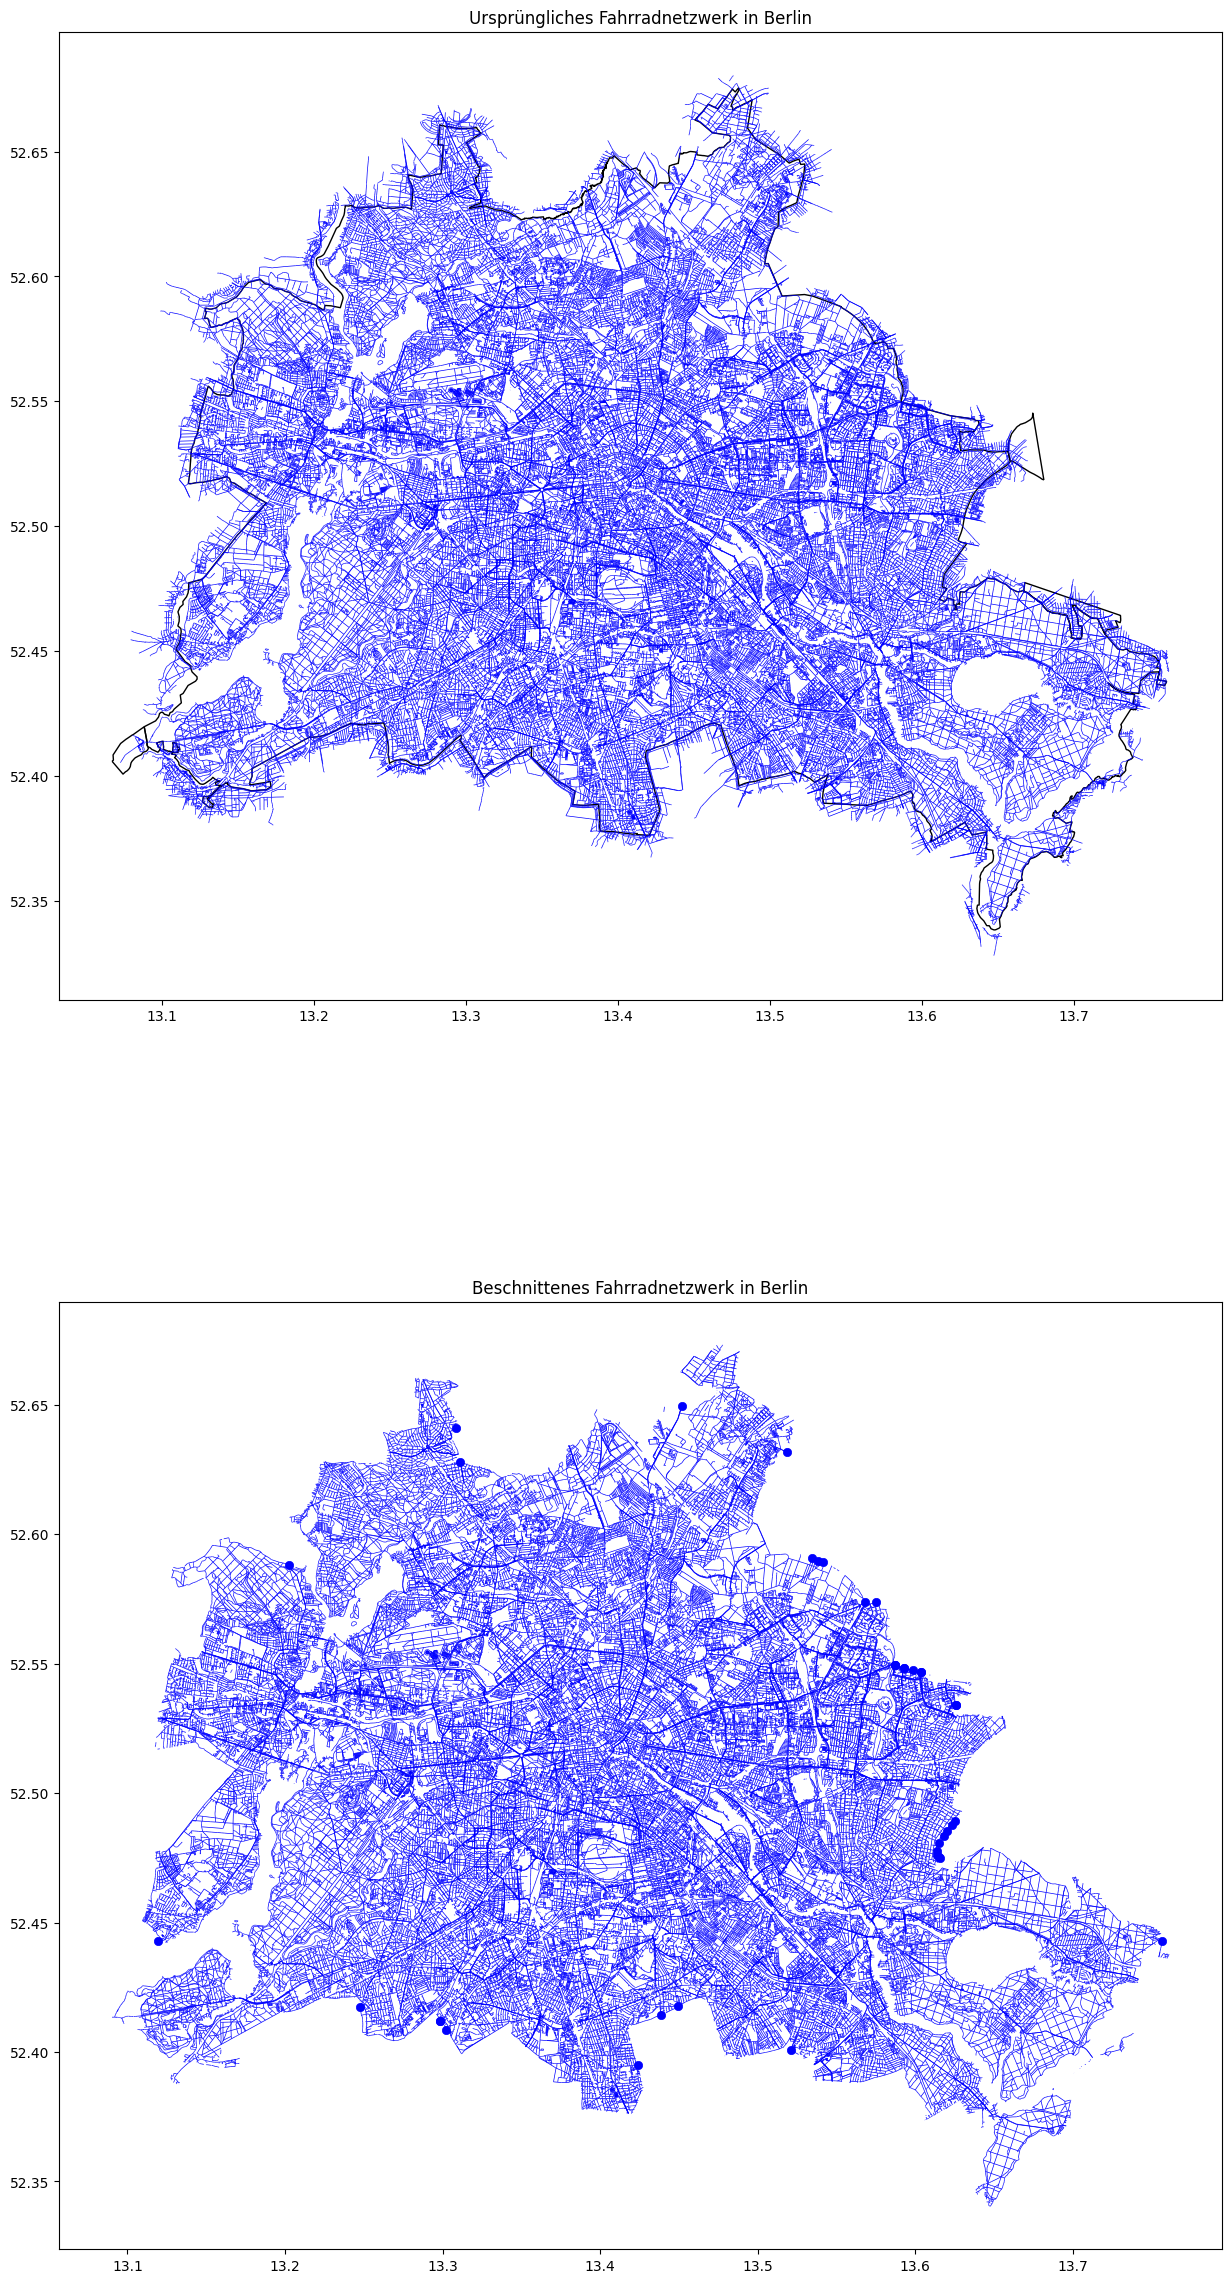

In [343]:
# Ursprüngliches Fahrradnetzwerk plotten
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
cycle_net_berlin.plot(ax=ax[0], color='blue', linewidth=0.5)
ax[0].set_title('Ursprüngliches Fahrradnetzwerk in Berlin')

# Grenzen von Berlin plotten
boundaries.plot(ax=ax[0], color='none', edgecolor='black', linewidth=1)

# Beschnittene Geometrie plotten
geom = cycle_net_berlin.geometry.apply(lambda x: x.intersection(berlin_boundary))
filtered_geom = geom[~geom.is_empty]

# Plot the intersected geometries
filtered_geom.plot(ax=ax[1], color='blue', linewidth=0.5)
ax[1].set_title('Beschnittenes Fahrradnetzwerk in Berlin')

plt.show()

In [347]:
# Überprüfen, ob Koordinatensysteme gleich sind
print(cycle_net_berlin.crs)
print(boundaries.crs)

epsg:4326
epsg:4326


###  Identifizieren & Entfernen von leeren Geometrien in `cycle_net_berlin`

Durch den Zuschnitt auf die administrative Grenze von Berlin können leere Geometrien entstehen. Dies kann passieren, wenn Teile des Fahrradnetzwerks außerhalb der Grenze liegen und dadurch vollständig vom Ergebnis ausgeschlossen werden.

**Mögliche Gründe** für leere Geometrien (nach Überschneiden mit Berliner Grenzen):

1. Wenn die ursprünglich vorhandene Geometrie eines Fahrradweges vollständig außerhalb der Berliner Grenze liegt, führt der `intersection`-Vorgang dazu, dass dieser Fahrradweg keine Schnittmenge mit der Berliner Grenze hat. Das resultierende Geometrieobjekt ist dann leer.

2. Bei Geometrien, die nach dem Zuschneiden nur teilweise innerhalb der Berliner Grenze liegen, könnte es sein, dass sehr kleine oder fragmentierte Überbleibselals leere Geometrien interpretiert werden.

In [348]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 9968


In [355]:
# Anzeigen der Details der leeren Geometrien (mit feature highway & lanes)
print(f"Details der leeren Geometrien:")
leere_geometrien[['geometry', 'highway']].head(3)

Details der leeren Geometrien:


geometry      highway
0  LINESTRING Z EMPTY  residential
5  LINESTRING Z EMPTY    secondary
6  LINESTRING Z EMPTY    secondary

### Entfernen leerer Geometrien

#### Begründung:

Datenqualität und Integrität:
   - keine Informationen durch leere Geometrien
   - Leere Geometrien können zu Fehlern oder ungenauen Ergebnissen in räumlichen Analysen und Berechnungen führen

In [356]:
# Entfernen von leeren Geometrien
cycle_net_berlin = cycle_net_berlin[~cycle_net_berlin.geometry.is_empty]

In [357]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


In [358]:
# Speichern der bereinigten Daten
output_file_name = "../../data/cycle_net_berlin_cleaned.geojson"
cycle_net_berlin.to_file(output_file_name, driver="GeoJSON")
print(f"Datei erfolgreich als GeoJSON gespeichert unter: {output_file_name}")

Datei erfolgreich als GeoJSON gespeichert unter: ../../data/cycle_net_berlin_cleaned.geojson


# Feature: Straßentypen (`highway`)
Straßentypen in OpenStreetMap-Daten sind unter dem Schlüssel `highway` gespeichert.

In [359]:
# Sicherstellen, dass die Spalte 'highway' existiert
if 'highway' not in cycle_net_berlin.columns:
    cycle_net_berlin['highway'] = "unknown"

In [362]:
# Extrahieren der relevanten Spalten 
highways = cycle_net_berlin[['geometry', 'highway']]

In [373]:
# Liste der verschiedenen Straßentypen und deren Häufigkeit im Netzwerk
highway_counts = highways['highway'].value_counts(normalize=True)*100
highway_counts.head()

highway
service        52.063664
residential    16.757703
secondary       6.449211
path            5.347240
cycleway        4.170216
Name: proportion, dtype: float64

In [369]:
highways.head()

geometry      highway
1  MULTILINESTRING ((13.53136 52.49263, 13.53136 ...  residential
2  MULTILINESTRING ((13.52694 52.48969, 13.52639 ...  residential
3  MULTILINESTRING ((13.52477 52.48558, 13.52484 ...  residential
4  MULTILINESTRING ((13.45420 52.51571, 13.45431 ...      primary
7  MULTILINESTRING ((13.37261 52.59296, 13.37347 ...  residential

### Erklärung zu den Straßentypen
Die Angaben beinhalten verschiedene Straßentypen, die in OSM verwendet werden, um unterschiedliche Arten von Wegen, Straßen und Pfaden zu kennzeichnen: 

1. service: Ein Dienstweg, eine Einfahrt o.ä., typisch in öffentlichen und privaten Einrichtungen, z.B. Zufahrtswege zu Parkplätzen oder Lagerhäusern.
2. residential: Straßen in Wohngebieten, die hauptsächlich für den Anwohnerverkehr gedacht sind.
3. track: Landwirtschaftliche oder forstwirtschaftliche Wege, die oft nicht asphaltiert sind.
4. path: Schmale Wege, oft unbefestigt, die für Fußgänger und manchmal auch für Fahrräder bestimmt sind.
5. secondary: Sekundärstraßen, die wichtige Verbindungen zwischen kleineren Städten oder Dörfern darstellen.
6. tertiary: Tertiärstraßen, die nicht die Hauptverbindungen darstellen, aber immer noch wichtige Verkehrswege sind.
7. footway: Gehwege, die ausschließlich für Fußgänger gedacht sind.
8. cycleway: Radwege, die ausschließlich für Fahrräder gedacht sind.
9. primary: Hauptverkehrsstraßen, die größere Städte oder Stadtteile verbinden, aber keine Autobahnen sind.
10. living_street: Verkehrsberuhigte Zonen, in denen Fußgänger Vorrang haben.
11. unclassified: Straßen, die keiner besonderen Klassifizierung zugeordnet sind, oft dörfliche Straßen oder andere Straßen niedriger Bedeutung.
12. pedestrian: Fußgängerzonen, die hauptsächlich für den Fußgängerverkehr gedacht sind.
13. trunk: Wichtige Hauptstraßen, die oft Schnellstraßen oder Autobahnen ähnlich sind, aber keine vollen Autobahnen.
14. bridleway: Reitwege, die für Pferde bestimmt sind.
15. trunk_link: Verbindungsstraßen, die auf Hauptstraßen (trunk) führen oder davon abzweigen.
16. secondary_link: Verbindungsstraßen, die auf sekundäre Straßen (secondary) führen oder davon abzweigen.
17. steps: Treppen, die für Fußgänger gedacht sind.
18. primary_link: Verbindungsstraßen, die auf primäre Straßen (primary) führen oder davon abzweigen.
19. construction: Straßen im Bau, die noch nicht fertiggestellt sind.
20. tertiary_link: Verbindungsstraßen, die auf tertiäre Straßen (tertiary) führen oder davon abzweigen.
21. bus_stop: Positionen von Bushaltestellen.
22. rest_area: Rastplätze entlang von Straßen.
23. services: Einrichtungen für Dienstleistungen, z.B. Tankstellen oder Raststätten.
24. elevator: Aufzüge, die für die Öffentlichkeit zugänglich sind.
25. busway: Separate Busspuren.
26. street_lamp: Straßenlaternen.
27. road: Straßen, die bearbeitet oder verbessert werden müssen oder nicht klassifiziert sind.
28. razed: Gelöschte Straßen oder Wege, die nicht mehr existieren.
29. proposed: Geplante Straßen oder Wege, die noch nicht gebaut wurden.

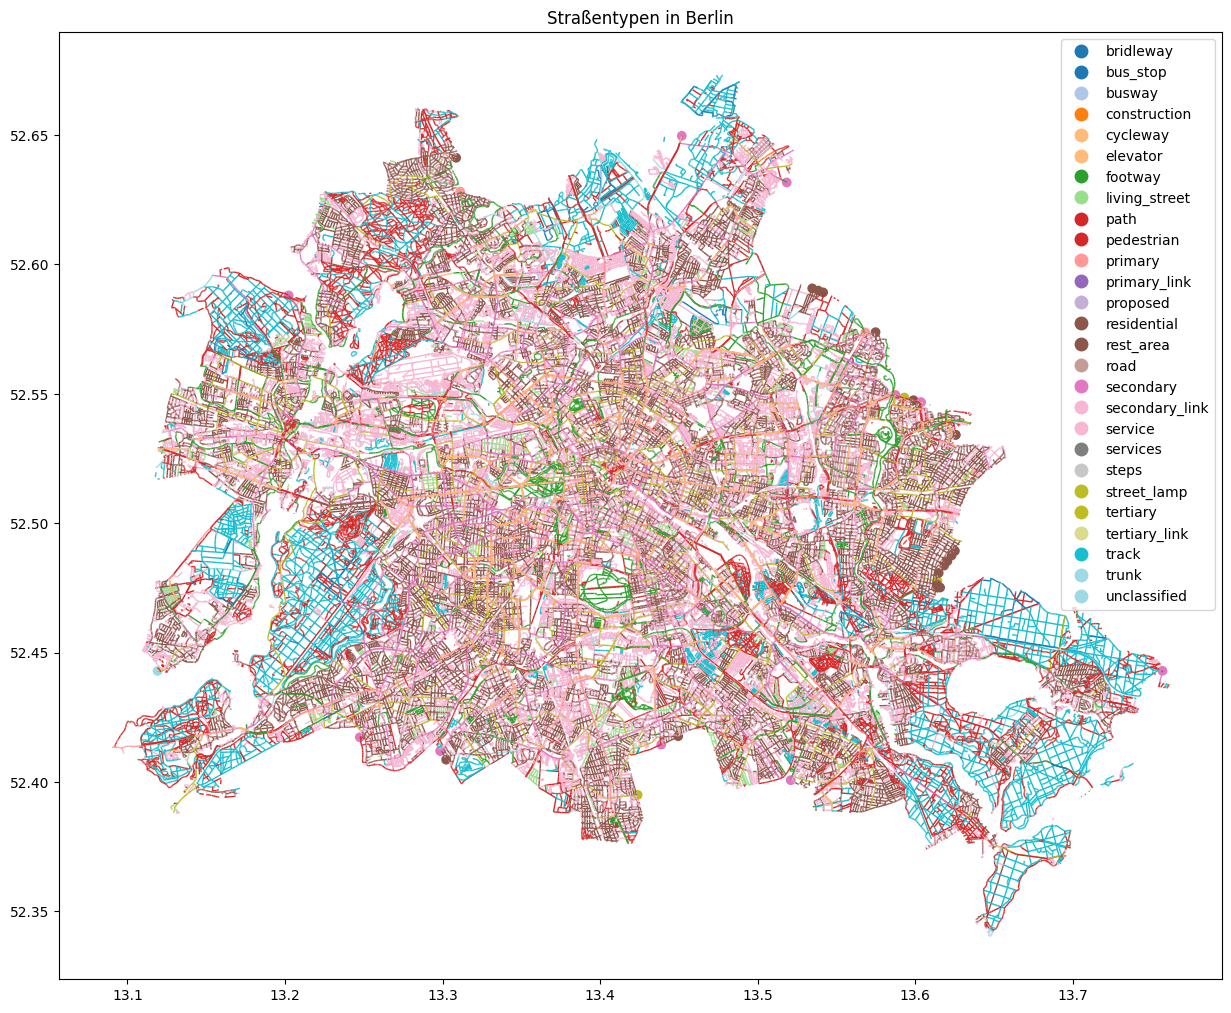

In [20]:
# Plotten des Straßennetzwerks
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Verwenden des 'tab20' Farbkarte, um bis zu 20 verschiedene Farben zu unterscheiden
base = cycle_net_berlin.plot(column='highway', ax=ax, legend=True,
                             cmap='tab20', linewidth=1, legend_kwds={'bbox_to_anchor': (1, 1)})

plt.title("Straßentypen in Berlin")
plt.show()

In [366]:
# Anzahl der Straßen ohne highway-Wert 
straßen_ohne_highway = cycle_net_berlin['highway'].isna().sum()

print(f"Anzahl der Straßen ohne highway-Wert: {straßen_ohne_highway}")

Anzahl der Straßen ohne highway-Wert: 0


In [33]:
# Speichern der gefilterten Straßentypen in einer GeoJSON-Datei

output_file_name = "../../data/processed_data/filtered_osm_highway_all.geojson"
highways.to_file(output_file_name, driver="GeoJSON")

print(f"Gefilterte Straßentypen wurden als GeoJSON-Datei gespeichert: {output_file_name}")

Gefilterte Straßentypen wurden als GeoJSON-Datei gespeichert: ../../data/processed_data/filtered_osm_highway.geojson


# Zusammenfassen seltener Straßentypen bei OSM 
Die Anzahl der verschiedenen Straßentypen bei OSM sehr groß ist und einige Typen kommen nur sehr selten (<1%) vor. Um die Daten zu vereinfachen und die Modellleistung zu verbessern, gehen wir wie folgt vor:

1. Alle Straßentypen (`highways`), deren Vorkommen unter 1% liegt, fassen wir als `highway_rare`zusammen in eine Kategorie.
2. Überprüfen der Berechtigung des Vorgehens:
   Um sicherzustellen, dass diese Methode sinnvoll ist und sowohl auf Trainings- als auch auf Testdaten angewendet werden kann, führen wir folgende Schritte durch:

   a. **Train-Test-Split**:
      Wir teilen den Datensatz in Trainings- und Testdaten auf.
      
   b. **Verteilungsprüfung**:
      Wir überprüfen die Verteilung der Straßentypen in den Trainings- und Testdaten, um sicherzustellen, dass die gleichen Straßentypen in beiden Datensätzen ebenfalls unter die 1 %-Schwelle fallen.

Durch diese Vorgehensweise stellen wir sicher, dass unser Ansatz sowohl konsistent als auch reproduzierbar ist, und die Klasse `highway_rare` sinnvoll für unsere Analysen und Modelle verwendet werden kann.

### 1. Verteilung der Straßentypen im gesamten Datensatz berechnen:

In [379]:
# verschiedene Straßentypen und deren Häufigkeit im Netzwerk
highway_counts = highways['highway'].value_counts(normalize=True)*100
highway_counts

highway
service           52.063664
residential       16.757703
secondary          6.449211
path               5.347240
cycleway           4.170216
tertiary           3.828307
footway            3.752062
track              2.740632
primary            2.330818
living_street      1.300921
unclassified       0.558133
pedestrian         0.256729
secondary_link     0.134619
bridleway          0.085179
primary_link       0.072075
steps              0.055992
construction       0.034548
tertiary_link      0.030974
trunk              0.010126
busway             0.008935
elevator           0.006552
street_lamp        0.002383
proposed           0.000596
road               0.000596
services           0.000596
rest_area          0.000596
bus_stop           0.000596
Name: proportion, dtype: float64

#### Selten vorkommende Straßentypen (<1%)

In [2]:
# Schwelle für seltene Straßentypen (< 1%)
threshold = 1

# Identifizieren von seltenen Straßentypen im gesamten Datensatz
rare_highways = highway_counts[highway_counts < threshold].index
print(f"Seltene Straßentypen im gesamten Datensatz (unter {threshold}%):")
print(rare_highways)

### 2. Splitten der Daten in Trainings- und Testdatensätze:

In [388]:
from sklearn.model_selection import train_test_split

# Splitten der Daten in Trainings- und Testdaten (80% Training, 20% Test)
train, test = train_test_split(cycle_net_berlin, test_size=0.2, random_state=1)

### 3. Verteilung der Straßentypen in den Trainings- und Testdatensätzen berechnen:

In [389]:
# Verteilung der Straßentypen im Trainingsdatensatz berechnen
train_highway_counts = train['highway'].value_counts(normalize=True)*100
print("Verteilung der Straßentypen im Trainingsdatensatz:")
print(train_highway_counts)

Verteilung der Straßentypen im Trainingsdatensatz:
highway
service           52.011109
residential       16.730701
secondary          6.478586
path               5.337146
cycleway           4.185281
tertiary           3.859155
footway            3.775762
track              2.716970
primary            2.336490
living_street      1.308226
unclassified       0.555456
pedestrian         0.266559
secondary_link     0.139981
bridleway          0.082648
primary_link       0.068501
steps              0.053610
tertiary_link      0.034995
construction       0.032761
trunk              0.008190
busway             0.008190
elevator           0.004467
street_lamp        0.002978
road               0.000745
rest_area          0.000745
bus_stop           0.000745
Name: proportion, dtype: float64


In [390]:
# Identifizieren von seltenen Straßentypen im Trainingsdatensatz
rare_train_highways = train_highway_counts[train_highway_counts < 1].index
print(f"Seltene Straßentypen im gesamten Datensatz (unter {threshold}%):")
print(rare_train_highways)

Seltene Straßentypen im gesamten Datensatz (unter 1%):
Index(['unclassified', 'pedestrian', 'secondary_link', 'bridleway',
       'primary_link', 'steps', 'tertiary_link', 'construction', 'trunk',
       'busway', 'elevator', 'street_lamp', 'road', 'rest_area', 'bus_stop'],
      dtype='object', name='highway')


In [391]:
# Verteilung der Straßentypen im Testdatensatz berechnen
test_highway_counts = test['highway'].value_counts(normalize=True)*100
print("Verteilung der Straßentypen im Testdatensatz:")
print(test_highway_counts)

Verteilung der Straßentypen im Testdatensatz:
highway
service           52.273878
residential       16.865712
secondary          6.331715
path               5.387617
cycleway           4.109956
tertiary           3.704917
footway            3.657265
track              2.835274
primary            2.308128
living_street      1.271704
unclassified       0.568842
pedestrian         0.217411
secondary_link     0.113173
bridleway          0.095303
primary_link       0.086369
steps              0.065521
construction       0.041695
trunk              0.017869
tertiary_link      0.014891
elevator           0.014891
busway             0.011913
proposed           0.002978
services           0.002978
Name: proportion, dtype: float64


In [392]:
# Identifizieren von seltenen Straßentypen im gesamten Datensatz
rare_test_highways = test_highway_counts[test_highway_counts < 1].index
print(f"Seltene Straßentypen im gesamten Datensatz (unter {threshold}%):")
print(rare_test_highways)

Seltene Straßentypen im gesamten Datensatz (unter 1%):
Index(['unclassified', 'pedestrian', 'secondary_link', 'bridleway',
       'primary_link', 'steps', 'construction', 'trunk', 'tertiary_link',
       'elevator', 'busway', 'proposed', 'services'],
      dtype='object', name='highway')


### Schlussfolgerung: 
- Die Verteilung der Straßentypen in den Trainings- und Testdatensätzen zeigt, dass die Straßenkategorien gleichmäßig und repräsentativ verteilt sind.
- Das deutet darauf hin, dass die gleichen Straßentypen auch nach der Zusammenfassung selten vorkommender Typen (<1 %) in den Trainings- und Testdaten ähnlich häufig vorkommen.

### Zusammenfassen der Straßentypen < 1% zu `highway_rare`

In [393]:
# Erstellen einer neuen Spalte und Ersetzen der seltenen Straßentypen durch 'highway_rare'
highways['highway'] = highways['highway'].apply(lambda x: 'highway_rare' if x in rare_highways else x)

highways.head()

geometry      highway
1  MULTILINESTRING ((13.53136 52.49263, 13.53136 ...  residential
2  MULTILINESTRING ((13.52694 52.48969, 13.52639 ...  residential
3  MULTILINESTRING ((13.52477 52.48558, 13.52484 ...  residential
4  MULTILINESTRING ((13.45420 52.51571, 13.45431 ...      primary
7  MULTILINESTRING ((13.37261 52.59296, 13.37347 ...  residential

In [394]:
# Straßentypen und deren Häufigkeit in %
highway_counts = highways['highway'].value_counts(normalize=True)*100
highway_counts

highway
service          52.063664
residential      16.757703
secondary         6.449211
path              5.347240
cycleway          4.170216
tertiary          3.828307
footway           3.752062
track             2.740632
primary           2.330818
living_street     1.300921
highway_rare      1.259225
Name: proportion, dtype: float64

# Visualisieren der einzelnen Straßentypen

In [397]:
streets = highways[highways['highway'] == 'cycleway']

<Axes: >

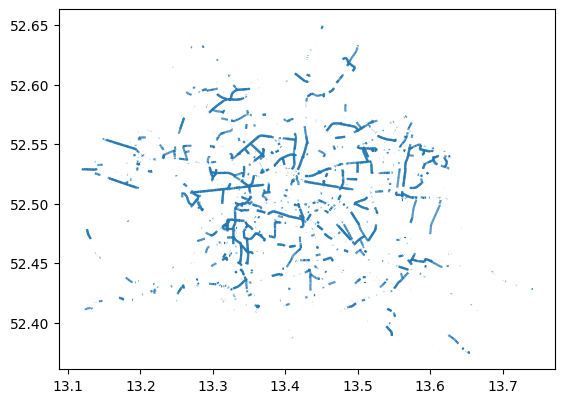

In [399]:
streets.plot()

In [410]:
# streets.explore()

### Nullwerte überprüfen

In [401]:
# Überprüfen, ob NaN-Werte vorhanden sind
print(highways.isnull().sum())

geometry    0
highway     0
dtype: int64


In [402]:
highways.describe()

geometry  highway
count                                          167881   167881
unique                                         167875       11
top     POINT (13.625675201416016 52.534122467041016)  service
freq                                                2    87405

In [403]:
highways.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 167881 entries, 1 to 177848
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  167881 non-null  geometry
 1   highway   167881 non-null  object  
dtypes: geometry(1), object(1)
memory usage: 3.8+ MB


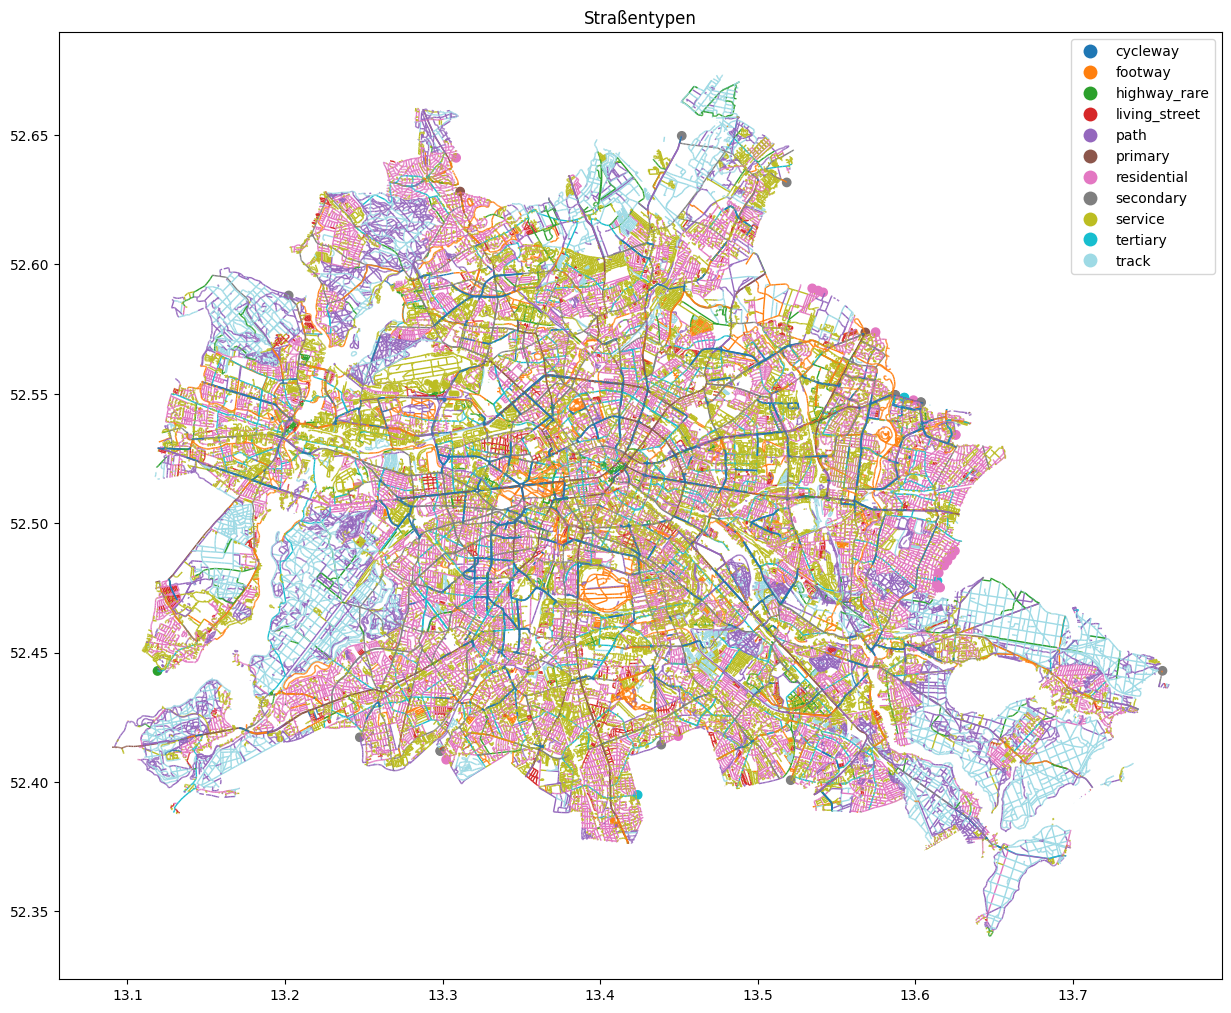

In [406]:
# Plotten des Straßennetzwerks, wobei die Farbe je nach Straßentyp (highway) variiert
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Verwenden des 'tab20' Farbkarte, um bis zu 20 verschiedene Farben zu unterscheiden
base = highways.plot(column='highway', ax=ax, legend=True,
                             cmap='tab20', linewidth=1, legend_kwds={'bbox_to_anchor': (1, 1)})

plt.title("Straßentypen")
plt.show()

In [224]:
# highways.explore()

In [408]:
print(highways['highway'].unique())

['residential' 'primary' 'secondary' 'living_street' 'tertiary' 'service'
 'highway_rare' 'path' 'footway' 'cycleway' 'track']


In [409]:
# Speichern der gefilterten Straßentypen in einer GeoJSON-Datei
output_file_name = "../../data/processed_data/filtered_osm_highway_v1.geojson"
highways.to_file(output_file_name, driver="GeoJSON")

print(f"Gefilterte Straßentypen wurden gespeichert.")

Gefilterte Straßentypen wurden gespeichert.


## Genauere Betrachtung des Straßentyps `service`

* Service ein Straßentyp, der für unseren Anwendungsfall nicht maßgeblich relevant ist, da es sich hierbei meist um Einfahrten und kurze Zufahrtsstraßen handelt.
* Da in vielen Polygonen eine verhältnismäßig große Anzahl `service` zugeordnet wird und somit das Verhältnis der Straßentypen maßgeblich beeinflusst wird, nehmen wir den `highway`-Typ `service` aus weiteren Betrachtungen heraus.

Vgl. hierzu folgende Notebooks: 
- [osm_highway_no_service](osm_highway_no_service.ipynb)
- [osm_surface_noservice](osm_surface_noservice.ipynb)
- [osm_maxspeed_noservice](osm_maxspeed_noservice.ipynb)

In [527]:
# Filtern der Zeilen, bei denen 'service' == 1
filtered_gdf = gdf[gdf['service'] == 1]

# Optional: Kontrolle der gefilterten Daten
filtered_gdf.head(3)

id                                           geometry    type  \
284   [103853].0  POLYGON ((13.44541 52.60121, 13.44538 52.60125...  Street   
470   [106282].0  POLYGON ((13.39488 52.48897, 13.39452 52.48899...  Street   
1578  [114486].0  POLYGON ((13.40549 52.53428, 13.40550 52.53426...  Street   

      score  incidents  rides markers  index_right  \
284     0.0          0     62     [ ]      30254.0   
470     0.0          0     51     [ ]      78442.0   
1578    0.0          0     54     [ ]     146612.0   

                                                highway  cycleway  footway  \
284   service, service, service, service, service, s...       0.0      0.0   
470                                             service       0.0      0.0   
1578                                            service       0.0      0.0   

      highway_rare  living_street  path  primary  residential  secondary  \
284            0.0            0.0   0.0      0.0          0.0        0.0   
470            0.0            0.0   0.0      0.0          0.0        0.0   
1578           0.0            0.0   0.0      0.0          0.0        0.0   

      service  tertiary  track  
284       1.0       0.0    0.0  
470       1.0       0.0    0.0  
1578      1.0       0.0    0.0

In [529]:
filtered_gdf['id'].count()

196

In [567]:
# Schritt 1: Filtern der Zeilen, bei denen 'service' == 1 und 'score' != 0
filtered_gdf = gdf[(gdf['rides'] < 20) & (gdf['score'] != 0)]

filtered_gdf.head(3)

id                                           geometry    type  \
75    [10141].0  POLYGON ((13.31050 52.60238, 13.31349 52.60364...  Street   
910  [109805].0  POLYGON ((13.38596 52.51560, 13.38600 52.51539...  Street   
959  [110021].0  POLYGON ((13.62441 52.44870, 13.62438 52.44839...  Street   

        score  incidents  rides  \
75   0.450000          2     12   
910  0.400000          1     11   
959  0.314286          1     14   

                                               markers  index_right  \
75   [ [ [ 13.311718000000001, 52.603003999999999 ]...       3993.0   
910  [ [ [ 13.38603035, 52.515711510000003 ], "Datu...      99469.0   
959  [ [ [ 13.62457172, 52.449958240000001 ], "Datu...     144490.0   

                                               highway  cycleway  footway  \
75   residential, service, residential, residential...       0.0      0.0   
910   residential, tertiary, primary, primary, primary       0.0      0.0   
959  service, service, service, service, service, s...       0.0      0.0   

     highway_rare  living_street  path  primary  residential  secondary  \
75            0.0            0.0   0.0      0.0     0.714286        0.0   
910           0.0            0.0   0.0      0.6     0.200000        0.0   
959           0.0            0.0   0.0      0.0     0.071429        0.0   

      service  tertiary  track  
75   0.285714  0.000000    0.0  
910  0.000000  0.200000    0.0  
959  0.857143  0.071429    0.0

In [531]:
filtered_gdf['id'].count()

29

### Ergebnis: 
- Es gibt insgesamt **196** Segmente/Polygone im Simra-Datensatz, denen nur der `highway`-Typ `service`zugeordnet wurden. Davon haben 29 Segmente einen `score` > 0.

In [2]:
import geopandas as gpd

path_file = "../../data/processed_data/osm_highway_ratios.geojson"

gdf = gpd.read_file(path_file)

In [4]:
gdf.head(3)

id      type  score  incidents  rides  \
0                            [100049].0    Street    0.0          0    138   
1                         [100069498].0  Junction    0.0          0    200   
2  [100078509, 288268004, 3888645535].0  Junction    0.0          0     54   

  markers  index_right                                            highway  \
0     [ ]      57832.0          secondary, secondary, cycleway, secondary   
1     [ ]     123443.0              residential, residential, residential   
2     [ ]      75145.0  secondary, secondary, cycleway, secondary, sec...   

   cycleway  footway  highway_rare  living_street  path  primary  residential  \
0  0.250000      0.0           0.0            0.0   0.0      0.0     0.000000   
1  0.000000      0.0           0.0            0.0   0.0      0.0     1.000000   
2  0.384615      0.0           0.0            0.0   0.0      0.0     0.153846   

   secondary  service  tertiary  track  \
0   0.750000      0.0       0.0    0.0   
1   0.000000      0.0       0.0    0.0   
2   0.461538      0.0       0.0    0.0   

                                            geometry  
0  POLYGON ((13.45412 52.54035, 13.45320 52.53977...  
1  POLYGON ((13.52273 52.50704, 13.52248 52.50690...  
2  POLYGON ((13.47754 52.51457, 13.47782 52.51438...

#### Das Merkmal `type`
- `type` ziehen wir in unsere weiteren Betrachtungen nicht mit ein, da dieses Feature sich nicht gleichwertig aus OSM extrahieren lässt. 

In [8]:
columns_to_drop = ['type']  

# Spalten löschen
gdf = gdf.drop(columns=columns_to_drop)

gdf.head()

id  score  incidents  rides  cycleway  \
0                            [100049].0    0.0          0    138  0.250000   
1                         [100069498].0    0.0          0    200  0.000000   
2  [100078509, 288268004, 3888645535].0    0.0          0     54  0.384615   
3                            [100094].0    0.0          0     98  0.000000   
4                              [1000].0    0.0          0    130  0.333333   

   footway  highway_rare  living_street  path  primary  residential  \
0      0.0           0.0            0.0   0.0      0.0     0.000000   
1      0.0           0.0            0.0   0.0      0.0     1.000000   
2      0.0           0.0            0.0   0.0      0.0     0.153846   
3      0.0           0.0            0.0   0.0      0.0     1.000000   
4      0.0           0.0            0.0   0.0      0.0     0.000000   

   secondary  service  tertiary  track  \
0   0.750000      0.0  0.000000    0.0   
1   0.000000      0.0  0.000000    0.0   
2   0.461538      0.0  0.000000    0.0   
3   0.000000      0.0  0.000000    0.0   
4   0.000000      0.0  0.666667    0.0   

                                            geometry  
0  POLYGON ((13.45412 52.54035, 13.45320 52.53977...  
1  POLYGON ((13.52273 52.50704, 13.52248 52.50690...  
2  POLYGON ((13.47754 52.51457, 13.47782 52.51438...  
3  POLYGON ((13.46855 52.61490, 13.46841 52.61475...  
4  POLYGON ((13.35533 52.51693, 13.35655 52.51683...

## Nächste Schritte
- `osm_highway` mit den SimRa-Daten verknüpfen
